In [139]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
import os
from sklearn.metrics import mean_squared_error
from datetime import date
import time
import matplotlib.pylab as plt
%matplotlib inline

In [254]:
class DataLoader():
    """
        DataLoader: Load the two data files into memory ready for cleaning and then merging
        - Final dataset is US-specific, two date columns for looking at weekly information pertaining to a particular region
    """

    dailyData = None
    weeklyData = None
    aggregateWeeklyData = None
    
    def subMedian(self, x, medians):
        num_cols = self.aggregateWeeklyData.dtypes[self.aggregateWeeklyData.dtypes == 'float64'].index.tolist()
        for col in num_cols:
            if col != 'hospitalized_new' and col != 'hospitalized_cumulative':
                x[col] = x[col] - medians[x['sub_region_1']]
        return x
    
    def normalizeSymptomsByRegionMedian(self):
        
        medians = self.aggregateWeeklyData.groupby("sub_region_1").median().iloc[:,:-2].median(axis=1)
        self.aggregateWeeklyData.iloc[:, 3:-3] = self.aggregateWeeklyData.iloc[:,:-3].apply(lambda x: self.subMedian(x, medians), axis=1).iloc[:,3:]
        print (self.aggregateWeeklyData)
    def generateDataSet(self):
        """
            generateDataSet: Generate final dataset by merging weeklySymptomData & weeklyHospitaliationData, based on sub_region_1
        """

        '''
        We want to see how symptoms aggregated across various Regions change over a Weekly time frame
        To do this, we merge the two dataframes based on geographical location, we have two date variables at the moment 
        '''
        self.aggregateWeeklyData = pd.merge(self.weeklySymptomData, self.weeklyHospitaliationData, how='inner', 
                                            left_on=['sub_region_1', 'date_symptoms'], right_on=['sub_region_1', 'date_hospitalization'])
        #replace NaN with avg value of column
        num_cols = self.aggregateWeeklyData.dtypes[self.aggregateWeeklyData.dtypes == 'float64'].index.tolist()
        for col in num_cols:
            self.aggregateWeeklyData[col].fillna(self.aggregateWeeklyData[col].mean(), inplace=True)
        
#         self.aggregateWeeklyData.drop(columns=["symptom:Trichoptilosis", "symptom:Angular cheilitis",
#                                                "symptom:Amenorrhea", "symptom:Allergic conjunctivitis",
#                                                "symptom:Urethritis",
#                                                "symptom:Urinary urgency", "symptom:Auditory hallucination",
#                                                "symptom:Balance disorder", "symptom:Beau's lines",
#                                                "symptom:Burning Chest Pain", "symptom:Cataplexy",
#                                                "symptom:Chorea", "symptom:Cleft lip and cleft palate",
#                                                "symptom:Clouding of consciousness", "symptom:Crepitus",
#                                                "symptom:Depersonalization", "symptom:Dysautonomia",
#                                                "symptom:Dyspareunia", "symptom:Dystonia",
#                                                "symptom:Dysuria", "symptom:Epiphora",
#                                                "symptom:Eye pain", "symptom:Facial swelling",
#                                                "symptom:Fibrocystic breast changes", "symptom:Focal seizure",
#                                                "symptom:Gastroparesis", "symptom:Gingival recession",
#                                                "symptom:Grandiosity", "symptom:Hemolysis",
#                                                "symptom:Hepatic encephalopathy", "symptom:Hepatotoxicity",
#                                                "symptom:Hydrocephalus", "symptom:Hypercalcaemia",
#                                                "symptom:Hyperemesis gravidarum", "symptom:Hypocalcaemia",
#                                                "symptom:Hypochondriasis", "symptom:Hypomania",
#                                                "symptom:Kyphosis", "symptom:Male infertility",
#                                                "symptom:Mitral insufficiency", "symptom:Myoclonus",
#                                                "symptom:Night terror", "symptom:Nocturnal enuresis",
#                                                "symptom:Nystagmus", "symptom:Onychorrhexis",
#                                                "symptom:Osteophyte", "symptom:Papule",
#                                                "symptom:Pericarditis", "symptom:Petechia",
#                                                "symptom:Photodermatitis", "symptom:Photophobia",
#                                                "symptom:Polydipsia", "symptom:Polyuria",
#                                                "symptom:Ptosis", "symptom:Rectal pain",
#                                                "symptom:Rectal prolapse", "symptom:Rumination",
#                                                "symptom:Sensitivity to sound", "symptom:Spasticity",
#                                                "symptom:Splenomegaly", "symptom:Stomach rumble",
#                                                "symptom:Subdural hematoma"], inplace=True)
        
        #normalize symptoms by regions median to make comparable across regions
        self.normalizeSymptomsByRegionMedian()
        
        return self.aggregateWeeklyData

    def cleanWeeklyAndDailyData(self):
        """
            cleanWeeklyAndDailyData: Remove empty values in the two dataframes, within respective bounds
        """
        
        '''
        weeklyData:
        - Drop all columns in weeklyData with more than 25 percent NaN values in a particular column
        - Drop all rows in weeklyData with more than 5 percent NaN values in a particular row
        - Rename Date column for distinction
        '''
        self.weeklyData.drop_duplicates(inplace=True)
        self.weeklyData.dropna(thresh=int(self.weeklyData.shape[0] * 0.25), inplace=True, axis='columns')
        self.weeklyData.dropna(thresh=int(self.weeklyData.shape[0] * 0.05), inplace=True, axis='index')   

        columnsToRemove = ['country_region_code', 'country_region', 'sub_region_1_code']
        self.weeklyData = self.weeklyData.drop(labels=columnsToRemove, axis='columns')

        self.weeklyData['date'] = self.weeklyData['date'].astype('datetime64[ns]')
        self.weeklyData.rename(columns={'date':'date_symptoms'}, inplace=True)

        '''
        dailyData:
        - Drop all columns in dailyData with more than 20 percent NaN values in a particular column
        - Drop all columns in dailyData of little-to-no interest
        - Rename Date column for distinction, rename region_name to match self.weeklyData.sub_region_1, before merging
        '''
        self.dailyData.dropna(thresh=int(self.dailyData.shape[0] * 0.2), inplace=True, axis='columns')
        self.dailyData = self.dailyData.get(['date', 'open_covid_region_code', 'region_name', 'hospitalized_new', 'hospitalized_cumulative'])
        self.dailyData.rename(columns={'region_name':'sub_region_1', 'date':'date_hospitalization'}, inplace=True)
        
        '''
        Iterate over the regions to discover the distinct 56 US States we want to analyze
        USRegionsList : List
        '''
        US_Regions_List = []
        for regionCode in self.dailyData['open_covid_region_code']:
            if ('US-' in regionCode and regionCode not in US_Regions_List):
                US_Regions_List.append(regionCode)

        '''
        Create a new dataframe subset (collection of rows) for a particular region
        Do this repeatedly to build a US_Daily_Table
        US_Daily_Table : DataFrame
        '''
        US_Daily_Table = None
        for US_Region in US_Regions_List:
            US_Region_Rows = self.dailyData.loc[self.dailyData['open_covid_region_code'] == US_Region]
            US_Daily_Table = pd.concat([US_Daily_Table, US_Region_Rows])
        
        '''
        Filter the above dataframe for non-zero values concerning the two hospitalization columns
        Populate self.dailyData with this new valid information
        '''
        indexNames = US_Daily_Table[(US_Daily_Table['hospitalized_new'] == 0.0) & (US_Daily_Table['hospitalized_cumulative'] == 0.0)].index
        US_Daily_Table.drop(indexNames, inplace=True)

        '''
        Convert daily dataframe into weekly, sorted alphabetically by region_name
        '''
        US_Daily_Table['date_hospitalization'] = US_Daily_Table['date_hospitalization'].astype('datetime64[ns]')
        US_Weekly_Table = US_Daily_Table.groupby("sub_region_1").resample('W-Mon', on='date_hospitalization').sum().reset_index()
        
        '''
        Set ptrs accordingly
        '''
        self.weeklySymptomData = self.weeklyData                            # Matrix ~ (312, 96)
        self.weeklyHospitaliationData = US_Weekly_Table                     # Matrix ~ (1052, 4)
        
        
    def loadRawData(self):
        """
            loadRawData: Init pandas dataframe for the two data files found within the data directory 
        Returns:
            DataFrame, DataFrame: Two pandas dataframe objects, one for each file 
        """
        dirname = os.getcwd()
        filename1 = os.path.join(dirname, '2020_US_weekly_symptoms_dataset.csv')
        filename2 = os.path.join(dirname, 'aggregated_cc_by.csv')
        DataSet1 = pd.read_csv(filename1, delimiter=',', dtype={"tests_new": float, "test_units": "string"})
        DataSet2 = pd.read_csv(filename2, delimiter=',', dtype={"tests_new": float, "test_units": "string"})
        return DataSet1, DataSet2

    def __init__(self) -> None:
        self.weeklyData, self.dailyData = self.loadRawData()
        self.cleanWeeklyAndDailyData()
        outputDataFrame = self.generateDataSet()
        # print(outputDataFrame)

dl = DataLoader()


    open_covid_region_code sub_region_1 date_symptoms  symptom:Adrenal crisis  \
0                    US-AK       Alaska    2020-03-30                   -0.02   
1                    US-AK       Alaska    2020-04-06                    1.10   
2                    US-AK       Alaska    2020-04-13                   -2.74   
3                    US-AK       Alaska    2020-04-20                   -1.58   
4                    US-AK       Alaska    2020-04-27                   -0.04   
..                     ...          ...           ...                     ...   
117                  US-WY      Wyoming    2020-08-31                    1.36   
118                  US-WY      Wyoming    2020-09-07                   -0.31   
119                  US-WY      Wyoming    2020-09-14                    0.48   
120                  US-WY      Wyoming    2020-09-21                    1.97   
121                  US-WY      Wyoming    2020-09-28                    6.12   

     symptom:Ageusia  sympt

In [255]:
class Cross_Validation:
    def cross_validate_regions(self, data, k, model):
        regions = pd.Series(data["sub_region_1"].unique())
        
        shuffled_regions = regions.sample(frac=1, random_state=0).reset_index(drop=True)
            
        split_regions = np.array_split(shuffled_regions, k)
        
        folds = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
     
        for i in range(k):
            for region in split_regions[i]:
                matched = data.loc[lambda data: data["sub_region_1"] == region]
                folds[i] = folds[i].append(matched)
        
        
        for i in range(k):
            folds[i].drop(columns=["sub_region_1", "date_symptoms",
                                   "date_hospitalization", "open_covid_region_code"], inplace=True)
        
        error_sum = 0
        
        for i in range(k):
            folds_to_train = folds.copy()
            fold_to_test = folds_to_train[i]
            del folds_to_train[i]
            folds_to_train = pd.concat(folds_to_train, sort=False)
            
            x_train = folds_to_train.loc[:,folds_to_train.columns != "hospitalized_new"]
            y_train = folds_to_train.loc[:,folds_to_train.columns == "hospitalized_new"]
            
            x_test = fold_to_test.loc[:,fold_to_test.columns != "hospitalized_new"]
            y_test = fold_to_test.loc[:,fold_to_test.columns == "hospitalized_new"]
            
            model.fit(x_train, y_train.values.ravel())
            predictions = model.predict(x_test)
            error_sum += mean_squared_error(predictions, y_test)
            
        return error_sum / k


In [256]:
cross = Cross_Validation()
data = dl.aggregateWeeklyData
print (data)

    open_covid_region_code sub_region_1 date_symptoms  symptom:Adrenal crisis  \
0                    US-AK       Alaska    2020-03-30                   -0.02   
1                    US-AK       Alaska    2020-04-06                    1.10   
2                    US-AK       Alaska    2020-04-13                   -2.74   
3                    US-AK       Alaska    2020-04-20                   -1.58   
4                    US-AK       Alaska    2020-04-27                   -0.04   
..                     ...          ...           ...                     ...   
117                  US-WY      Wyoming    2020-08-31                    1.36   
118                  US-WY      Wyoming    2020-09-07                   -0.31   
119                  US-WY      Wyoming    2020-09-14                    0.48   
120                  US-WY      Wyoming    2020-09-21                    1.97   
121                  US-WY      Wyoming    2020-09-28                    6.12   

     symptom:Ageusia  sympt

In [257]:
lr = LinearRegression()
d = data.copy()
d.drop(columns=["sub_region_1", "date_symptoms", "date_hospitalization", "open_covid_region_code"], inplace=True)
sets = np.array_split(d, 2)
x_train = sets[0].loc[:,sets[0].columns != "hospitalized_new"]
y_train = sets[0].loc[:,sets[0].columns == "hospitalized_new"]

x_test = sets[1].loc[:,sets[1].columns != "hospitalized_new"]
y_test = sets[1].loc[:,sets[1].columns == "hospitalized_new"]

lr.fit(x_train, y_train)
predictions = lr.predict(x_test)
error = mean_squared_error(predictions, y_test)
print(error)

877.8993749549898


30
767.0890132090133
{1: 0.061872005462646484, 2: 0.05485272407531738, 3: 0.056303977966308594, 4: 0.056916236877441406, 5: 0.057071685791015625, 6: 0.05603432655334473, 7: 0.057030439376831055, 8: 0.056438446044921875, 9: 0.056172847747802734, 10: 0.075408935546875, 11: 0.0582423210144043, 12: 0.05927610397338867, 13: 0.05701875686645508, 14: 0.055106163024902344, 15: 0.057091474533081055, 16: 0.05882596969604492, 17: 0.058348655700683594, 18: 0.05901527404785156, 19: 0.057769060134887695, 20: 0.05983924865722656, 21: 0.05585074424743652, 22: 0.058196067810058594, 23: 0.057845115661621094, 24: 0.05993914604187012, 25: 0.06334614753723145, 26: 0.05784416198730469, 27: 0.05585074424743652, 28: 0.054853200912475586, 29: 0.05485343933105469, 30: 0.054852962493896484, 31: 0.05485343933105469, 32: 0.054853200912475586, 33: 0.054853200912475586, 34: 0.054853200912475586, 35: 0.05498623847961426, 36: 0.05512285232543945, 37: 0.05509495735168457, 38: 0.06077146530151367, 39: 0.0590550899505615

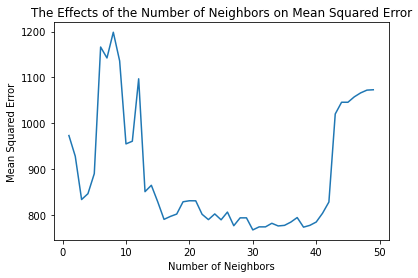

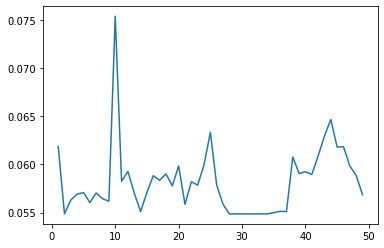

In [258]:
# KNN using ball_tree algo
times = {}
num_neighbours = {}
for i in range(1,50):
    start_time = time.time()
    num_neighbours[i] = cross.cross_validate_regions(data, 5, neighbors.KNeighborsClassifier(n_neighbors=i, algorithm='ball_tree'))
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])
print (times)
lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of the Number of Neighbors on Mean Squared Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()


30
767.0890132090133
0.06385922431945801


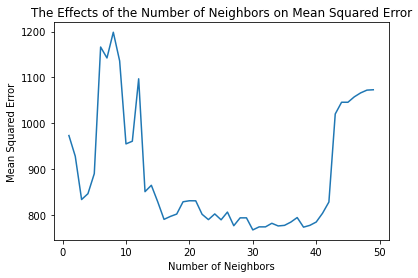

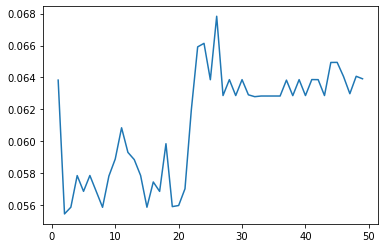

In [259]:
# KNN using kd-tree algo
times = {}
num_neighbours = {}
for i in range(1,50):
    start_time = time.time()
    num_neighbours[i] = cross.cross_validate_regions(data, 5, neighbors.KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree'))
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])
print (times[m])

lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of the Number of Neighbors on Mean Squared Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()


In [260]:
class TimeSeparator:
    def separate_at_date(self, data, date):
        data.drop(columns=["sub_region_1", "date_symptoms", "open_covid_region_code"], inplace=True)
        train = pd.DataFrame()
        test = pd.DataFrame()
        matched = data.loc[lambda data: data["date_hospitalization"] <= date]
        train = train.append(matched)
        matched = data.loc[lambda data: data["date_hospitalization"] > date]
        test = train.append(matched)
        test.drop(columns=["date_hospitalization"], inplace=True)
        train.drop(columns=["date_hospitalization"], inplace=True)
        return train, test


In [261]:
ts = TimeSeparator()

1
843.9053923853924
0.10692334175109863


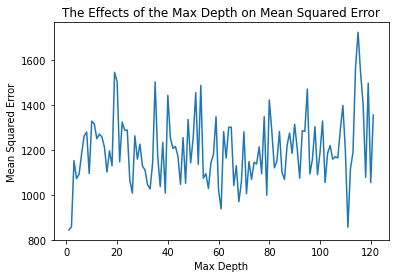

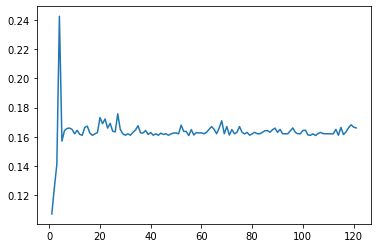

In [262]:
times = {}
num_neighbours = {}

for i in range(1,122):
    start_time = time.time()
    num_neighbours[i] = cross.cross_validate_regions(data, 5, DecisionTreeClassifier(max_depth=i, criterion='entropy'))
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])
print (times[m])

lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of the Max Depth on Mean Squared Error')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()

10
1033.0124527324529
0.0967414379119873


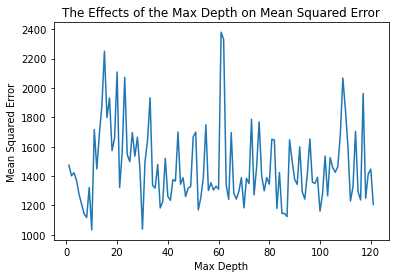

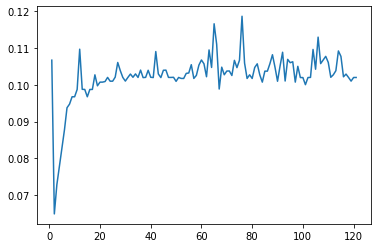

In [263]:
times = {}
num_neighbours = {}

for i in range(1,122):
    start_time = time.time()
    num_neighbours[i] = cross.cross_validate_regions(data, 5, DecisionTreeClassifier(max_depth=i))
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])
print (times[m])

lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of the Max Depth on Mean Squared Error')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()

In [264]:
# Date separated data
d = data.copy()
train, test = ts.separate_at_date(d, "2020-08-10")
x_train = train.loc[:,train.columns != "hospitalized_new"]
y_train = train.loc[:,train.columns == "hospitalized_new"]

x_test = test.loc[:,test.columns != "hospitalized_new"]
y_test = test.loc[:,test.columns == "hospitalized_new"]


In [265]:
class Model_Runner:
    def run_model(self, model, xtrain, ytrain, xtest, ytest):
        model.fit(xtrain, ytrain)
        predictions = model.predict(xtest)
        return mean_squared_error(predictions, ytest)

35
504.3688524590164
0.020667314529418945


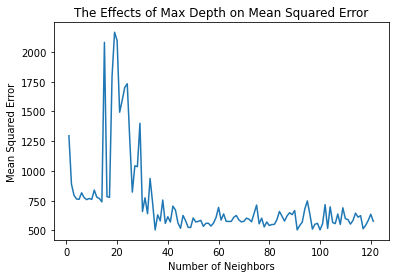

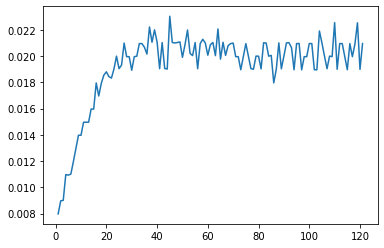

In [266]:
times = {}
num_neighbours = {}

for i in range(1,122):
    start_time = time.time()
    num_neighbours[i] = runner.run_model(DecisionTreeClassifier(max_depth=i), x_train, y_train, x_test, y_test)
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])
print (times[m])

lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of Max Depth on Mean Squared Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()

62
289.655737704918
0.0329129695892334


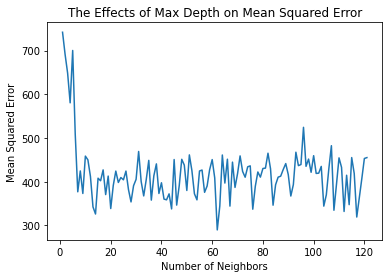

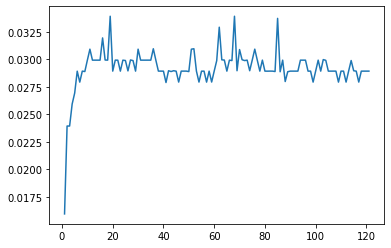

In [202]:
times = {}
num_neighbours = {}

for i in range(1,122):
    start_time = time.time()
    num_neighbours[i] = runner.run_model(DecisionTreeClassifier(criterion="entropy", max_depth=i), x_train, y_train, x_test, y_test)
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])
print (times[m])
lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of Max Depth on Mean Squared Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()

1
398.4918032786885
0.010934114456176758


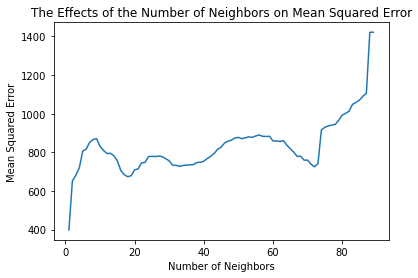

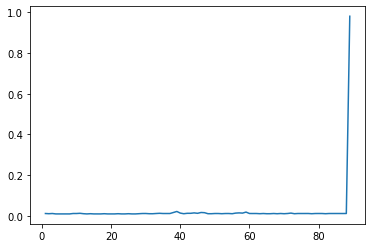

In [203]:
# KNN using ball tree algo
times = {}
num_neighbours = {}
for i in range(1,90):
    start_time = time.time()
    num_neighbours[i] = runner.run_model(neighbors.KNeighborsClassifier(n_neighbors=i, algorithm="ball_tree"), x_train, y_train.values.ravel(), x_test, y_test)
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])
print (times[m])
for k in range(1,len(times.keys())):
    times[i] = times[i] + times[i-1] 
lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of the Number of Neighbors on Mean Squared Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()

1
398.4918032786885
0.05681204795837402


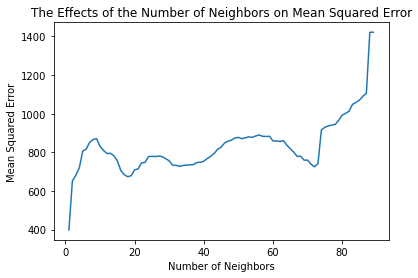

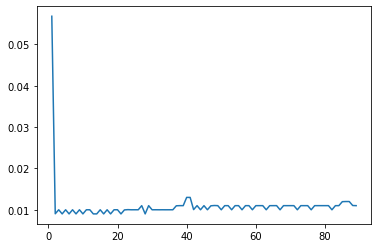

In [204]:
# KNN using ball tree algo
times = {}
num_neighbours = {}
for i in range(1,90):
    start_time = time.time()
    num_neighbours[i] = runner.run_model(neighbors.KNeighborsClassifier(n_neighbors=i, algorithm="kd_tree"), x_train, y_train.values.ravel(), x_test, y_test)
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])

print(times[m])


lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of the Number of Neighbors on Mean Squared Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()